# Analysis of the amenities around airports in the United States

# ----------------------------------------------------------------------------------------------------

Import and install required packages

In [1]:
!pip install requests
!pip install bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
!conda install -c conda-forge folium=0.5.0 --yes
import folium
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
print('All imported.')

     |████████████████████████████████| 122kB 1.0MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    attrs-21.2.0               |     pyhd8ed1ab_0          44 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    entrypoints-0.3            |  pyhd8ed1ab_1003           8 KB  conda-forge
    folium-0.5.0     

<br>

Our data analysis is done in 5 steps: <br>
1. Get the input data;
2. Get the venues around each airport using Foursquare; <br>
3. Determine the top 10 types of venues around each airport; <br>
4. Cluster the airports; <br>
5. Analysis of the clusters; <br>
6. Repeat clustering for the restaurants only. 

### __1. Get the input data__

<br> Fetch airport data <br>
To do so, we first use BeautifulSoup and find the correct tables.

In [22]:
# Parse url using BeatifulSoup
url="https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States"
data  = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")
#soup
# Find all tables
tables=soup.find_all('table')
print(len(tables))

13


We found that the tables of interest are tables[0] and tables[1]. <br>

In [23]:
#tables[0]
type(tables[0].find_all('td'))

bs4.element.ResultSet

Each line of the tables contains a link to the wikipedia page of a given airport. <br>
Let us open one of these links and see how we can fetch the lattitude and longitude of the corresponding airport.

In [24]:
myurl="https://en.wikipedia.org/wiki/Hartsfield%E2%80%93Jackson_Atlanta_International_Airport"
mydata  = requests.get(myurl).text
mydata=mydata.split("Coordinates")

In [25]:
mydata[3]

'</a></th><td class="infobox-data"><style data-mw-deduplicate="TemplateStyles:r994658806">.mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}</style><span class="plainlinks nourlexpansion"><a rel="nofollow" class="external text" href="//geohack.toolforge.org/geohack.php?pagename=Hartsfield%E2%80%93Jackson_Atlanta_International_Airport&amp;params=33_38_12_N_084_25_41_W_region:US-GA_type:airport"><span class="geo-default"><span class="geo-dms" title="Maps, aerial photos, and other data for this location"><span class="latitude">33°38′12″N</span> <span class="longitude">084°25′41″W</span></span></span><span class="geo-multi-punct">&#xfeff; / &#xfeff;</span><span class="geo-nondefault"><span class="geo-dec" title="Maps, aerial photos, and other data for this location">33.63667°N 84.42806

It looks like the 4th element of the text from the json file, mydata[3], contains the information that we need, right after span class="geo". <br>
We obtain a 2-element list by doing some basic processing to the text:

In [26]:
mydata[3].split('span class="geo">')[1].split("<")[0].split(";")

['33.63667', ' -84.42806']

Now that we found the information on one example, we repeat teh process for every airport, ie: for each line of the two tables from BeautifulSoup, namely, tables[0] and tables[1]. <br>
We also fill the dataframe that will be our input data.

In [27]:
# Initialize the dataframe
df=pd.DataFrame(columns=['Airport name','Code','City','State','Passengers','Latitude','Longitude'])
df

,Airport name,Code,City,State,Passengers,Latitude,Longitude


In [28]:
# Start with tables[0]
# Loop on each line of the table
for val in tables[0].find_all("tr"):
    # Find the columns of each line
    col = val.find_all("td")
    if (col!=[]):
        # The web address of the airport is in col[1]
        web = col[1].find_all('a',href=True)
        myurl="https://en.wikipedia.org"+web[0].get('href')
        # Get the web page as json from the url
        mydata  = requests.get(myurl).text
        print(col[1].text.strip())
        # Find latitude and longitude of the airport
        latlong=mydata.split('span class="geo">')[1].split("<")[0].split(";")
        # Fill the dataframe      
        df=df.append({'Airport name':col[1].text.strip(),'Code':col[2].text.strip(),'City':col[3].text.strip(),'State':col[4].text.strip(),'Passengers':col[5].text.strip(),
                      'Latitude':float(latlong[0]),'Longitude':float(latlong[1])},ignore_index=True)
                      
df.head(10)

Hartsfield-Jackson International Airport
Dallas/Fort Worth International Airport
Denver International Airport
O'Hare International Airport
Los Angeles International Airport
Charlotte Douglas International Airport
McCarran International Airport
Phoenix Sky Harbor International Airport
Orlando International Airport
Seattle–Tacoma International Airport
Miami International Airport
George Bush Intercontinental Airport
Fort Lauderdale–Hollywood International Airport
San Francisco International Airport
John F. Kennedy International Airport
Minneapolis–Saint Paul International Airport
Newark Liberty International Airport
Detroit Metropolitan Airport
Logan International Airport
Salt Lake City International Airport
Philadelphia International Airport
Baltimore/Washington International Airport
Tampa International Airport
San Diego International Airport
Chicago Midway International Airport
Washington Dulles International Airport
Nashville International Airport
LaGuardia Airport
Dallas Love Field
Ro

,Airport name,Code,City,State,Passengers,Latitude,Longitude
0,Hartsfield-Jackson International Airport,ATL,Atlanta,GA,"42,918,685",33.63667,-84.42806
1,Dallas/Fort Worth International Airport,DFW,Dallas & Ft. Worth,TX,"39,364,990",32.89694,-97.03806
2,Denver International Airport,DEN,Denver,CO,"33,741,129",39.86167,-104.67306
3,O'Hare International Airport,ORD,Chicago,IL,"30,860,251",41.97861,-87.90472
4,Los Angeles International Airport,LAX,Los Angeles,CA,"28,779,527",33.94250,-118.40806
5,Charlotte Douglas International Airport,CLT,Charlotte,NC,"27,205,082",35.21389,-80.94306
6,McCarran International Airport,LAS,Las Vegas,NV,"22,201,479",36.08000,-115.15222
7,Phoenix Sky Harbor International Airport,PHX,Phoenix,AZ,"21,978,708",33.43417,-112.01167
8,Orlando International Airport,MCO,Orlando,FL,"21,617,803",28.42944,-81.30889
9,Seattle–Tacoma International Airport,SEA,Seattle,WA,"20,061,507",47.44889,-122.30944


In [29]:
# Next, process tables[1]
# Loop on each line of the table
for val in tables[1].find_all("tr"):
    # Find the columns of each line
    col = val.find_all("td")
    if (col!=[]):
        # The web address of the airport is in col[1]
        web = col[1].find_all('a',href=True)
        myurl="https://en.wikipedia.org"+web[0].get('href')
        # Get the web page as json from the url
        mydata  = requests.get(myurl).text
        print(col[1].text.strip())
        # Find latitude and longitude of the airport
        latlong=mydata.split('span class="geo">')[1].split("<")[0].split(";")
        # Fill the dataframe       
        df=df.append({'Airport name':col[1].text.strip(),'Code':col[2].text.strip(),'City':col[3].text.strip(),'State':col[4].text.strip(),'Passengers':col[5].text.strip(),
                      'Latitude':float(latlong[0]),'Longitude':float(latlong[1])},ignore_index=True)
                      
df.tail(10)

Daniel K. Inouye International Airport
William P. Hobby Airport
Austin–Bergstrom International Airport
St. Louis Lambert International Airport
Southwest Florida International Airport[15]
Sacramento International Airport
Louis Armstrong New Orleans International Airport
Raleigh-Durham International Airport
Luis Muñoz Marín International Airport
Norman Y. Mineta San José International Airport
Oakland International Airport
Kansas City International Airport
Cleveland Hopkins International Airport
Indianapolis International Airport
San Antonio International Airport
John Wayne Airport
Pittsburgh International Airport
Cincinnati/Northern Kentucky International Airport
John Glenn Columbus International Airport
Palm Beach International Airport
Jacksonville International Airport
Milwaukee Mitchell International Airport
Ontario International Airport
Bradley International Airport
Kahului Airport
Ted Stevens Anchorage International Airport
Eppley Airfield
Memphis International Airport
Reno–Tahoe In

,Airport name,Code,City,State,Passengers,Latitude,Longitude
50,Palm Beach International Airport,PBI,West Palm Beach,FL,"3,085,200",26.68306,-80.09556
51,Jacksonville International Airport,JAX,Jacksonville,FL,"2,842,711",30.49417,-81.68778
52,Milwaukee Mitchell International Airport,MKE,Milwaukee,WI,"2,627,215",42.94722,-87.89667
53,Ontario International Airport,ONT,Ontario,CA,"2,538,482",34.05611,-117.60111
54,Bradley International Airport,BDL,Hartford,CT,"2,427,478",41.93917,-72.68333
55,Kahului Airport,OGG,Kahului,HI,"2,377,529",20.89861,-156.43056
56,Ted Stevens Anchorage International Airport,ANC,Anchorage,AK,"2,157,100",61.17417,-149.99833
57,Eppley Airfield,OMA,Omaha,NE,"2,140,016",41.30000,-95.89500
58,Memphis International Airport,MEM,Memphis,TN,"2,029,836",35.04250,-89.97667
59,Reno–Tahoe International Airport,RNO,Reno,NV,"2,006,420",39.49917,-119.76806


In [30]:
df.to_csv("airport_list.csv", index=False)

Our input data is ready. <br>
Let us plot a map with the airport locations.

In [13]:
# Using latitude-longitude of Memphis
latitude=40.0
longitude=-105.0
map_airports = folium.Map(location=[latitude, longitude], zoom_start=4)
# add markers to map
for lat, lng, name, city in zip(df['Latitude'], df['Longitude'], df['Airport name'], df['City']):
    label = '{}, {}'.format(name, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_airports)

In [1]:
map_airports

Github does not display folium maps so I am including a .PNG version.

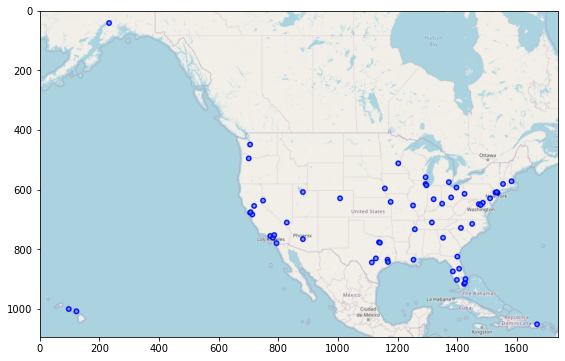

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as img
plt.figure(figsize = (10,6))
im0 = img.imread('map_airports.PNG')
plt.imshow(im0)

### __2. Get the venues around each airport using Foursquare__

Prepare for foursquare calls.

In [15]:
CLIENT_ID = '3ODJVZ4F3SGCVG42QGI2G11U0CZZ5GNJGGL2TEIL152PU4DB' # your Foursquare ID
CLIENT_SECRET = 'KKLQFUVBNQWIOTTAVT0T2AMFJ00BKLFEZYICDXL2YFR0SHE1' # your Foursquare Secret
VERSION = '20180604'

Define a function that returns the venues in the vicinniti of a given airport.

In [16]:
def getvenues(lat,long,airportname,radius,limit):
    # Define url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius,
            limit)
    
    # Get request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # Create list of venues
    venues_list=([[airportname,v['venue']['name'],v['venue']['categories'][0]['name']] for v in results])
        
    #print(venues_list)
    return(venues_list)

Test the function

In [17]:
radius=10000
limit=1000
mylat=33.63667
mylon=-84.42806
myname='Hartsfield-Jackson International Airport'
print(getvenues(mylat,mylon,myname,radius,limit))

[['Hartsfield-Jackson International Airport', 'Chicken & Beer', 'Fried Chicken Joint'], ['Hartsfield-Jackson International Airport', 'One Flew South', 'Sushi Restaurant'], ['Hartsfield-Jackson International Airport', 'Delta Sky Club', 'Airport Lounge'], ['Hartsfield-Jackson International Airport', 'The Sky Deck', 'Roof Deck'], ['Hartsfield-Jackson International Airport', 'Delta Sky Club', 'Airport Lounge'], ['Hartsfield-Jackson International Airport', 'Delta Flight Museum', 'Museum'], ['Hartsfield-Jackson International Airport', 'Delta Sky Priority Check-in', 'Airport Service'], ['Hartsfield-Jackson International Airport', 'A Walk through Atlanta History', 'Exhibit'], ['Hartsfield-Jackson International Airport', 'Fresh Healthy Cafe', 'Snack Place'], ['Hartsfield-Jackson International Airport', 'Delta 747 Museum', 'Museum'], ['Hartsfield-Jackson International Airport', 'The Corner Grille', 'Restaurant'], ['Hartsfield-Jackson International Airport', "L'Occitane en Provence", 'Cosmetics S

It works! <br>
Let us repeat that for all the airports and store the result into a dataframe.

In [18]:
venues=pd.DataFrame(columns=['Airport name','Venue name','Venue type'])
venues

,Airport name,Venue name,Venue type


In [19]:
radius=10000
limit=1000

for i in df.index:
    myname=df.loc[i,'Airport name']
    mylat=df.loc[i,'Latitude']
    mylon=df.loc[i,'Longitude']
    print(myname)
    myvenues=getvenues(mylat,mylon,myname,radius,limit)
    dftemp = pd.DataFrame(myvenues, columns = venues.columns)
    venues=venues.append(dftemp,ignore_index=True)
    print('Done')
    print(' ')
    
print('All airports parsed')

Hartsfield-Jackson International Airport
Done
 
Dallas/Fort Worth International Airport
Done
 
Denver International Airport
Done
 
O'Hare International Airport
Done
 
Los Angeles International Airport
Done
 
Charlotte Douglas International Airport
Done
 
McCarran International Airport
Done
 
Phoenix Sky Harbor International Airport
Done
 
Orlando International Airport
Done
 
Seattle–Tacoma International Airport
Done
 
Miami International Airport
Done
 
George Bush Intercontinental Airport
Done
 
Fort Lauderdale–Hollywood International Airport
Done
 
San Francisco International Airport
Done
 
John F. Kennedy International Airport
Done
 
Minneapolis–Saint Paul International Airport
Done
 
Newark Liberty International Airport
Done
 
Detroit Metropolitan Airport
Done
 
Logan International Airport
Done
 
Salt Lake City International Airport
Done
 
Philadelphia International Airport
Done
 
Baltimore/Washington International Airport
Done
 
Tampa International Airport
Done
 
San Diego Internat

Let us examine our dataframe a little bit.

In [136]:
venues

,Airport name,Venue name,Venue type
0,Hartsfield-Jackson International Airport,Chicken & Beer,Fried Chicken Joint
1,Hartsfield-Jackson International Airport,One Flew South,Sushi Restaurant
2,Hartsfield-Jackson International Airport,Delta Sky Club,Airport Lounge
3,Hartsfield-Jackson International Airport,The Sky Deck,Roof Deck
4,Hartsfield-Jackson International Airport,Delta Sky Club,Airport Lounge
...,...,...,...
5992,Reno–Tahoe International Airport,The Daily Bagel,Café
5993,Reno–Tahoe International Airport,Bistro 7,American Restaurant
5994,Reno–Tahoe International Airport,Grand Sierra Resort and Casino,Resort
5995,Reno–Tahoe International Airport,The Shore Riverfront Dining,American Restaurant


In [135]:
venues.head()

,Airport name,Venue name,Venue type
0,Hartsfield-Jackson International Airport,Chicken & Beer,Fried Chicken Joint
1,Hartsfield-Jackson International Airport,One Flew South,Sushi Restaurant
2,Hartsfield-Jackson International Airport,Delta Sky Club,Airport Lounge
3,Hartsfield-Jackson International Airport,The Sky Deck,Roof Deck
4,Hartsfield-Jackson International Airport,Delta Sky Club,Airport Lounge


In [92]:
venues.shape

(5997, 3)

Our venue dataset is ready. <br>
Let us store venues into a .csv file, so we don't have to call foursquare again if we get disconnected.

In [93]:
venues.to_csv("airport_venues.csv", index=False)

In [3]:
venues=pd.read_csv('airport_venues.csv')
venues.head()

,Airport name,Venue name,Venue type
0,Hartsfield-Jackson International Airport,Chicken & Beer,Fried Chicken Joint
1,Hartsfield-Jackson International Airport,One Flew South,Sushi Restaurant
2,Hartsfield-Jackson International Airport,Delta Sky Club,Airport Lounge
3,Hartsfield-Jackson International Airport,The Sky Deck,Roof Deck
4,Hartsfield-Jackson International Airport,Delta Sky Club,Airport Lounge


In [4]:
df=pd.read_csv('airport_list.csv')
df.head()

,Airport name,Code,City,State,Passengers,Latitude,Longitude
0,Hartsfield-Jackson International Airport,ATL,Atlanta,GA,"42,918,685",33.63667,-84.42806
1,Dallas/Fort Worth International Airport,DFW,Dallas & Ft. Worth,TX,"39,364,990",32.89694,-97.03806
2,Denver International Airport,DEN,Denver,CO,"33,741,129",39.86167,-104.67306
3,O'Hare International Airport,ORD,Chicago,IL,"30,860,251",41.97861,-87.90472
4,Los Angeles International Airport,LAX,Los Angeles,CA,"28,779,527",33.94250,-118.40806


### __3. Determine the top 10 types of venues around each airport__

To do this, we apply the one hot encoding to the venues dataset and compute the mean value for each airport, for each venues type. That gives us the proportion of each venue type in each airport. Then, we sort and pick the 10 venues type with highest proportion.

In [5]:
# one hot encoding
venues_onehot= pd.get_dummies(venues[['Venue type']], prefix="", prefix_sep="")
venues_onehot[venues.columns]=venues[venues.columns]
list_columns=list(venues_onehot.columns)
list_columns.insert(0, list_columns.pop(list_columns.index('Airport name')))
list_columns.insert(1, list_columns.pop(list_columns.index('Venue name')))
list_columns.insert(1, list_columns.pop(list_columns.index('Venue type')))
venues_onehot=venues_onehot[list_columns]
venues_onehot.head()

,Airport name,Venue type,Venue name,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Hartsfield-Jackson International Airport,Fried Chicken Joint,Chicken & Beer,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hartsfield-Jackson International Airport,Sushi Restaurant,One Flew South,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hartsfield-Jackson International Airport,Airport Lounge,Delta Sky Club,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Hartsfield-Jackson International Airport,Roof Deck,The Sky Deck,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hartsfield-Jackson International Airport,Airport Lounge,Delta Sky Club,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# This can be use to simply count the venues but is not necessary for the purpose of this work
#vcount=venues_onehot.groupby('Airport name').count().reset_index()
#vcount.head(10)

Compute mean of each column per airport.

In [7]:
vmean=venues_onehot.groupby('Airport name').mean().reset_index()
vmean.head()

,Airport name,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Austin–Bergstrom International Airport,0.0,0.00,0.0,0.00,0.0,0.00,0.01,0.00,0.00,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.01,0.00,0.0
1,Baltimore/Washington International Airport,0.0,0.01,0.0,0.02,0.0,0.01,0.00,0.02,0.00,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0
2,Bradley International Airport,0.0,0.00,0.0,0.00,0.0,0.00,0.01,0.01,0.01,...,0.0,0.0,0.0,0.00,0.00,0.01,0.0,0.00,0.00,0.0
3,Charlotte Douglas International Airport,0.0,0.00,0.0,0.00,0.0,0.00,0.01,0.00,0.00,...,0.0,0.0,0.0,0.01,0.01,0.00,0.0,0.01,0.00,0.0
4,Chicago Midway International Airport,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.01,0.0


Create a dataframe with the 10 venue types with the highest distribution.

In [8]:
numax=10

# Create columns
colist=['Airport name']
for i in range(numax):
    colist.append("C"+str(i+1))

# Create dataframe
venues_sorted=pd.DataFrame(columns=colist)

# Populate dataframe
nmax=numax+1
for i in vmean.index:
    myrow=vmean.iloc[i,1:].sort_values(ascending=False)
    myrow2=[vmean.iloc[i,0]]+list(myrow.index.values)
    venues_sorted.loc[i,:]=myrow2[0:11]
venues_sorted.head()

,Airport name,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,Austin–Bergstrom International Airport,Coffee Shop,Food Truck,Brewery,Pizza Place,Convenience Store,Hotel,Music Venue,BBQ Joint,Trail,Racetrack
1,Baltimore/Washington International Airport,Hotel,Sandwich Place,Seafood Restaurant,American Restaurant,Fast Food Restaurant,Toy / Game Store,Pizza Place,Mexican Restaurant,Convenience Store,Asian Restaurant
2,Bradley International Airport,Hotel,American Restaurant,Sandwich Place,Italian Restaurant,Donut Shop,Pizza Place,Breakfast Spot,Pharmacy,Asian Restaurant,Liquor Store
3,Charlotte Douglas International Airport,Brewery,Bar,BBQ Joint,Mexican Restaurant,Grocery Store,Restaurant,Deli / Bodega,American Restaurant,Sushi Restaurant,Bakery
4,Chicago Midway International Airport,Pizza Place,Mexican Restaurant,Ice Cream Shop,Grocery Store,Brewery,Breakfast Spot,Liquor Store,Hot Dog Joint,American Restaurant,Bakery


Unfortunately, we can see that a lots of venues that appear in different categories are similar. For example, several types of restaurants appear in separate categories, such as "Seafood Restaurant', or "Mexican Restaurant. This has the strong potential for biasing our study, since each specific restaurant category has the same weigth as another, separate category such as "Hotel", for example. <br>
For the purpose of this study, it makes more sense to group similar categories into a single category. For instance, we will group all the restaurant as the category "Restaurant", and all the bars as the "Bar" category, which includes "Pub", "Beer Garden", etc... <br>
We will actually study the proportion of the different types of restaurants on their own later in this study, in a specific section.

In [9]:
# Create a new dataframe
venues_onehot2=venues_onehot.copy()

# We will remove the venues inside teh airport terminal by removing all columns that contain the word "Airport" later.
# We rename the column "Airport name" temporarily in order not to drop it later.
venues_onehot2 = venues_onehot2.rename(columns={'Airport name': 'name'})
#venues_onehot2.head()

In [10]:
# Group similar categories into single categories

mydict={}
mydict['Restaurant']=[col for col in venues_onehot2.columns if 'Restaurant' in col or 'Joint' in col or 'Place' in col or 'Food Truck' in col 
                      or 'Steakhouse' in col or 'Noodle House' in col or 'Diner' in col or 'breakfast' in col.lower() or 'bagel' in col.lower()]
mydict['Bar']=[col for col in venues_onehot2.columns if 'Bar' in col or 'Brewery' in col or 'pub' in col.lower() or 'Beer Garden' in col or 'bodega' in col.lower()]
mydict['Groceries']=[col for col in venues_onehot2.columns if 'market' in col.lower() or 'grocer' in col.lower()]
mydict['Ice Cream']=[col for col in venues_onehot2.columns if 'ice cream' in col.lower() or 'frozen yogurt' in col.lower()]
mydict['Gym']=[col for col in venues_onehot2.columns if 'gym' in col.lower() or 'fitness center' in col.lower()]
mydict['Airport']=[col for col in venues_onehot2.columns if 'airport' in col.lower()]
mydict['Coffee Place']=[col for col in venues_onehot2.columns if 'coffee shop' in col.lower() or 'donut' in col.lower()]

#mydict

In [11]:
# Define columns an the auxiliary dataframe
colaux=list(mydict.keys())

# Create an auxiliary dataframe
aux=pd.DataFrame(columns=colaux)

# Populate the auxiliary dataframe and drop corresponding columns from the venues_onehot2 dataframe
for val in colaux:
    aux[val]=venues_onehot2[mydict[val]].sum(axis=1)
    venues_onehot2.drop(mydict[val],axis=1,inplace = True)
print(colaux)

# Finallly, populate the venues_onehot2 dataframe with the columns of the auxiliary dataframe
venues_onehot2[colaux]=aux[colaux]
venues_onehot2.head()

['Restaurant', 'Bar', 'Groceries', 'Ice Cream', 'Gym', 'Airport', 'Coffee Place']


,name,Venue type,Venue name,ATM,Accessories Store,Advertising Agency,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Yoga Studio,Zoo,Zoo Exhibit,Restaurant,Bar,Groceries,Ice Cream,Gym,Airport,Coffee Place
0,Hartsfield-Jackson International Airport,Fried Chicken Joint,Chicken & Beer,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Hartsfield-Jackson International Airport,Sushi Restaurant,One Flew South,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Hartsfield-Jackson International Airport,Airport Lounge,Delta Sky Club,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Hartsfield-Jackson International Airport,Roof Deck,The Sky Deck,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hartsfield-Jackson International Airport,Airport Lounge,Delta Sky Club,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# Remove all columns contaning the word "Airport" and put back the 'Airport name' column name
venues_onehot2.drop('Airport',axis=1,inplace = True)
venues_onehot2 = venues_onehot2.rename(columns={'name':'Airport name'})
venues_onehot2.head()

,Airport name,Venue type,Venue name,ATM,Accessories Store,Advertising Agency,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Restaurant,Bar,Groceries,Ice Cream,Gym,Coffee Place
0,Hartsfield-Jackson International Airport,Fried Chicken Joint,Chicken & Beer,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Hartsfield-Jackson International Airport,Sushi Restaurant,One Flew South,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Hartsfield-Jackson International Airport,Airport Lounge,Delta Sky Club,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hartsfield-Jackson International Airport,Roof Deck,The Sky Deck,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hartsfield-Jackson International Airport,Airport Lounge,Delta Sky Club,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Noe we are ready to determine the 10 mostly present categories using the new dataframe by using the same procedure as before.

In [13]:
# Compute mean of each column per airport.
vmean2=venues_onehot2.groupby('Airport name').mean().reset_index()
vmean2.head(10)

,Airport name,ATM,Accessories Store,Advertising Agency,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,...,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Restaurant,Bar,Groceries,Ice Cream,Gym,Coffee Place
0,Austin–Bergstrom International Airport,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.01,0.00,0.0,0.34,0.14,0.00,0.02,0.01,0.12
1,Baltimore/Washington International Airport,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.0,0.47,0.05,0.01,0.02,0.01,0.03
2,Bradley International Airport,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.0,0.42,0.06,0.02,0.02,0.04,0.06
3,Charlotte Douglas International Airport,0.0,0.00,0.0,0.0,0.0,0.01,0.0,0.0,0.01,...,0.0,0.01,0.00,0.0,0.32,0.17,0.06,0.00,0.03,0.01
4,Chicago Midway International Airport,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.00,0.01,0.0,0.51,0.08,0.06,0.06,0.01,0.04
5,Cincinnati/Northern Kentucky International Air...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.01,0.00,0.0,0.55,0.03,0.02,0.04,0.03,0.02
6,Cleveland Hopkins International Airport,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.0,0.36,0.14,0.03,0.04,0.04,0.06
7,Dallas Love Field,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.0,0.49,0.11,0.05,0.01,0.02,0.06
8,Dallas/Fort Worth International Airport,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.0,0.47,0.06,0.03,0.01,0.01,0.06
9,Daniel K. Inouye International Airport,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.0,0.42,0.08,0.04,0.01,0.01,0.04


In [14]:
numax=10
# Create columns
colist=['Airport name']
for i in range(numax):
    colist.append("C"+str(i+1))

# Create dataframe
venues_sorted2=pd.DataFrame(columns=colist)

# Populate dataframe
nmax=numax+1
for i in vmean2.index:
    myrow=vmean2.iloc[i,1:].sort_values(ascending=False)
    myrow2=[vmean2.iloc[i,0]]+list(myrow.index.values)
    venues_sorted2.loc[i,:]=myrow2[0:11]
    
venues_sorted2.head()

,Airport name,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,Austin–Bergstrom International Airport,Restaurant,Bar,Coffee Place,Convenience Store,Hotel,Racetrack,Trail,Music Venue,Garden Center,Discount Store
1,Baltimore/Washington International Airport,Restaurant,Hotel,Bar,Coffee Place,Convenience Store,Toy / Game Store,Warehouse Store,Scenic Lookout,Liquor Store,Ice Cream
2,Bradley International Airport,Restaurant,Hotel,Bar,Coffee Place,Gym,Pharmacy,Groceries,Convenience Store,Liquor Store,Museum
3,Charlotte Douglas International Airport,Restaurant,Bar,Groceries,Gym,Bakery,Clothing Store,Park,Gift Shop,Convenience Store,Miscellaneous Shop
4,Chicago Midway International Airport,Restaurant,Bar,Ice Cream,Groceries,Coffee Place,Liquor Store,Bakery,Clothing Store,Military Base,Soccer Stadium


It turns out that 'Restaurant' is the most present category in all airport, so it is not a significant category for our analysis, and might even bias the result. So we drop the 'Restaurant' category. <br>
We will analyze the restaurants separately in section 6.

In [15]:
vmean2.drop('Restaurant',axis=1,inplace = True)
numax=10
# Create columns
colist=['Airport name']
for i in range(numax):
    colist.append("C"+str(i+1))

# Create dataframe
venues_sorted2=pd.DataFrame(columns=colist)

# Populate dataframe
nmax=numax+1
for i in vmean2.index:
    myrow=vmean2.iloc[i,1:].sort_values(ascending=False)
    myrow2=[vmean2.iloc[i,0]]+list(myrow.index.values)
    venues_sorted2.loc[i,:]=myrow2[0:11]
    
venues_sorted2.head()

,Airport name,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,Austin–Bergstrom International Airport,Bar,Coffee Place,Convenience Store,Hotel,Racetrack,Trail,Music Venue,Ice Cream,Discount Store,Garden Center
1,Baltimore/Washington International Airport,Hotel,Bar,Coffee Place,Toy / Game Store,Convenience Store,Ice Cream,Liquor Store,Scenic Lookout,Warehouse Store,Pet Store
2,Bradley International Airport,Hotel,Bar,Coffee Place,Gym,Pharmacy,Groceries,Convenience Store,Liquor Store,Museum,Pet Store
3,Charlotte Douglas International Airport,Bar,Groceries,Gym,Bakery,Clothing Store,Park,Gift Shop,Convenience Store,Miscellaneous Shop,Coffee Place
4,Chicago Midway International Airport,Bar,Ice Cream,Groceries,Coffee Place,Liquor Store,Bakery,Clothing Store,Military Base,Soccer Stadium,Other Great Outdoors


Now the categories and distribution appear more appropriate to our study, so we are ready to attempt clustering.

### __4. Cluster the airports__

In this section, we first try clustering the aiports using the k-means algorithm. <br>
The first step is to determine the optimal number of clusters, that produces a low error, but without being too large and produce over-fitting. Over-fitting is a particularly risk in this study, as dividing into too many clusters will make the analysis overly challenging and erroneous. <br>
<br> We try a number of clusters between 2 and 10 and compute the distance to the centroids.

In [16]:
# Drop the airport name
venues_train=vmean2.drop('Airport name',axis=1).copy()

# Set the maximum number of clusters for error analysis and initialyze the error table to 0
kmax=10
error=np.zeros(kmax+1)

# Loop through each number of clusters from 2 to 10
for i in range(2,kmax+1):
    order=i
    #print('Order=',order)
    # Cluster the dataset into i groups
    kmean_loc=KMeans(n_clusters=order, random_state=0)
    kmean_loc.fit(venues_train)
    
    # Copy the dataset and add a column contaning the cluster labels
    mydf=venues_train.copy()
    mydf['Label']=kmean_loc.labels_
    
    # Compute sum of squared error, ie: the sum of squared distance from each point to the centroid
    for j in range(i):
        A=mydf[mydf['Label']==j].drop('Label',axis=1).to_numpy()
        error[i]=error[i]+((A-kmean_loc.cluster_centers_[j])**2).mean()
    
    # Compute the mean squared error
    error[i]=error[i]/i
    print('Error at k=',i,'=',error[i])

Error at k= 2 = 3.474099644626176e-05
Error at k= 3 = 3.047262196249277e-05
Error at k= 4 = 2.5147386664476528e-05
Error at k= 5 = 2.522679520135787e-05
Error at k= 6 = 2.5097592909498913e-05
Error at k= 7 = 2.4130438650740132e-05
Error at k= 8 = 1.9119964106464016e-05
Error at k= 9 = 1.996369631487433e-05
Error at k= 10 = 1.760259372759169e-05


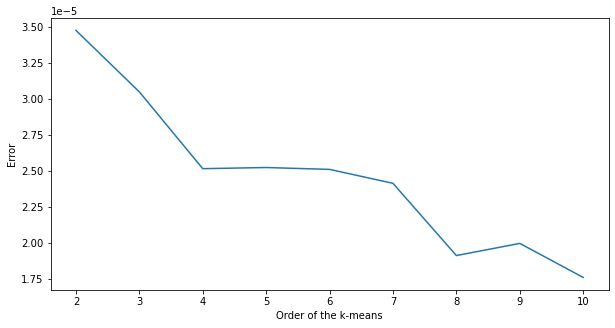

In [17]:
# Plot the error for each number of clusters from 2 to 10
orders=range(2,kmax+1)
plt.figure(figsize=(10,5))
plt.plot(orders,error[2:11])
plt.xlabel('Order of the k-means')
plt.ylabel('Error')
plt.show()

We notice a kick on the graph where the order is equal to 4. The fact that there are only 60 aiports in our dataset is another reason to use a number of clusters equal to 4. <br>
Then we repeat the k-means fitting using k=4.

In [18]:
mykmean=KMeans(n_clusters=4, random_state=0,n_init=1)
mykmean.fit(venues_train)
mykmean.labels_[0:10]

array([0, 3, 3, 2, 2, 1, 0, 2, 3, 2], dtype=int32)

Put the labels into the initial dataset.

In [19]:
airport_labelled=pd.DataFrame(columns=['Airport name','Label'])
airport_labelled['Airport name']=vmean2['Airport name']
airport_labelled['Label']=mykmean.labels_
airport_labelled.head()

,Airport name,Label
0,Austin–Bergstrom International Airport,0
1,Baltimore/Washington International Airport,3
2,Bradley International Airport,3
3,Charlotte Douglas International Airport,2
4,Chicago Midway International Airport,2


In [20]:
finaldf=airport_labelled.join(df.set_index('Airport name'), on='Airport name')
finaldf.head(12)

,Airport name,Label,Code,City,State,Passengers,Latitude,Longitude
0,Austin–Bergstrom International Airport,0,AUS,Austin,TX,"6,472,579",30.19444,-97.67000
1,Baltimore/Washington International Airport,3,BWI,Baltimore,MD,"11,204,511",39.17528,-76.66833
2,Bradley International Airport,3,BDL,Hartford,CT,"2,427,478",41.93917,-72.68333
3,Charlotte Douglas International Airport,2,CLT,Charlotte,NC,"27,205,082",35.21389,-80.94306
4,Chicago Midway International Airport,2,MDW,Chicago,IL,"8,853,948",41.78611,-87.75250
5,Cincinnati/Northern Kentucky International Air...,1,CVG,Cincinnati/Covington,OH/KY,"3,615,139",39.04889,-84.66778
6,Cleveland Hopkins International Airport,0,CLE,Cleveland,OH,"4,122,517",41.41167,-81.84972
7,Dallas Love Field,2,DAL,Dallas,TX,"7,684,653",32.84722,-96.85167
8,Dallas/Fort Worth International Airport,3,DFW,Dallas & Ft. Worth,TX,"39,364,990",32.89694,-97.03806
9,Daniel K. Inouye International Airport,2,HNL,Honolulu,HI,"6,656,825",21.31861,-157.92250


Plot the clustered airport on a map.

In [21]:
# create map
latitude=40.0
longitude=-105.0
nclusters=4
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=4.45)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i + x + (i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, city, cluster in zip(finaldf['Latitude'], finaldf['Longitude'], finaldf['Airport name'], finaldf['City'], finaldf['Label']):
    label='{}, {}, {}'.format(poi, city, ' Cluster ' + str(cluster))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

Github does not display folium maps so I am including a .PNG version.

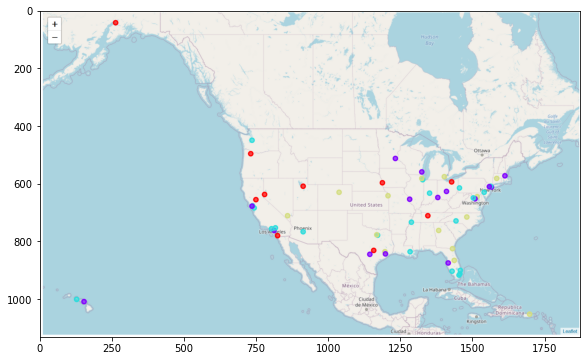

In [3]:
plt.figure(figsize = (10,6))
im1 = img.imread('map_cluster1.PNG')
plt.imshow(im1)

### __5. Analysis of the clusters__

Get the venue types and cluster labels in the same dataset.

In [22]:
analysis=airport_labelled.join(venues_sorted2.set_index('Airport name'), on='Airport name')
analysis.head()

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,Austin–Bergstrom International Airport,0,Bar,Coffee Place,Convenience Store,Hotel,Racetrack,Trail,Music Venue,Ice Cream,Discount Store,Garden Center
1,Baltimore/Washington International Airport,3,Hotel,Bar,Coffee Place,Toy / Game Store,Convenience Store,Ice Cream,Liquor Store,Scenic Lookout,Warehouse Store,Pet Store
2,Bradley International Airport,3,Hotel,Bar,Coffee Place,Gym,Pharmacy,Groceries,Convenience Store,Liquor Store,Museum,Pet Store
3,Charlotte Douglas International Airport,2,Bar,Groceries,Gym,Bakery,Clothing Store,Park,Gift Shop,Convenience Store,Miscellaneous Shop,Coffee Place
4,Chicago Midway International Airport,2,Bar,Ice Cream,Groceries,Coffee Place,Liquor Store,Bakery,Clothing Store,Military Base,Soccer Stadium,Other Great Outdoors


Analyze the venues in each cluster separately.

In [23]:
analysis[analysis['Label']==0]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,Austin–Bergstrom International Airport,0,Bar,Coffee Place,Convenience Store,Hotel,Racetrack,Trail,Music Venue,Ice Cream,Discount Store,Garden Center
6,Cleveland Hopkins International Airport,0,Bar,Park,Coffee Place,Ice Cream,Gym,Bakery,Groceries,Chocolate Shop,Café,Hotel
12,Eppley Airfield,0,Bar,Hotel,Coffee Place,Ice Cream,Zoo Exhibit,Rental Car Location,Historic Site,Lounge,Candy Store,Monument / Landmark
33,Nashville International Airport,0,Bar,Coffee Place,Trail,Dog Run,Music Venue,Café,Pet Store,Park,Gym,Groceries
44,Portland International Airport,0,Bar,Coffee Place,Groceries,Ice Cream,Hotel,Park,Café,Bakery,Pet Store,Beer Store
46,Reno–Tahoe International Airport,0,Bar,Coffee Place,Café,Spa,Gym,Sporting Goods Shop,Groceries,Miscellaneous Shop,Art Gallery,Shoe Store
48,Sacramento International Airport,0,Bar,Coffee Place,Rental Car Location,Park,Groceries,Gym,Ice Cream,Hotel,Bubble Tea Shop,Electronics Store
49,Salt Lake City International Airport,0,Bar,Coffee Place,Hotel,Groceries,Bakery,Theater,Park,Paper / Office Supplies Store,Scenic Lookout,Basketball Stadium
51,San Diego International Airport,0,Bar,Zoo Exhibit,Coffee Place,Park,Groceries,Hotel,Museum,Theater,Bakery,Zoo
57,Ted Stevens Anchorage International Airport,0,Coffee Place,Bar,Park,Groceries,Sporting Goods Shop,Gift Shop,Bakery,Hardware Store,Rental Car Location,Café


Counting the number of occurences of each venues helps with the analysis.

In [24]:
mydf=analysis[analysis['Label']==0].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

Bar                              10
Coffee Place                     10
Groceries                         8
Hotel                             7
Park                              7
Ice Cream                         5
Bakery                            5
Café                              5
Gym                               4
Rental Car Location               3
Zoo Exhibit                       2
Music Venue                       2
Theater                           2
Trail                             2
Sporting Goods Shop               2
Pet Store                         2
Electronics Store                 1
Monument / Landmark               1
Zoo                               1
Chocolate Shop                    1
Scenic Lookout                    1
Racetrack                         1
Candy Store                       1
Historic Site                     1
Basketball Stadium                1
Discount Store                    1
Shoe Store                        1
Miscellaneous Shop          

In [25]:
analysis[analysis['Label']==1]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
5,Cincinnati/Northern Kentucky International Air...,1,Ice Cream,Bar,Gym,Coffee Place,Liquor Store,Hotel,Rental Car Location,Groceries,Yoga Studio,Office
18,John F. Kennedy International Airport,1,Beach,Bar,Coffee Place,Bakery,Surf Spot,Groceries,Gym,Sporting Goods Shop,Clothing Store,Pool
19,John Glenn Columbus International Airport,1,Ice Cream,Coffee Place,Groceries,Bar,Furniture / Home Store,Gym,Cosmetics Shop,Park,Garden,Smoke Shop
20,John Wayne Airport,1,Groceries,Coffee Place,Gym,Bar,Shopping Mall,Furniture / Home Store,Park,Bakery,Liquor Store,Women's Store
21,Kahului Airport,1,Groceries,Café,Coffee Place,Ice Cream,Bar,Beach,Bakery,Miscellaneous Shop,Department Store,Rental Car Location
24,Logan International Airport,1,Park,Bar,Bakery,Coffee Place,Hotel,Groceries,Historic Site,Gym,Science Museum,Pet Store
31,Milwaukee Mitchell International Airport,1,Bar,Coffee Place,Park,Groceries,Gym,Dog Run,Hotel,Record Shop,Beach,Music Venue
32,Minneapolis–Saint Paul International Airport,1,Bar,Coffee Place,Groceries,Trail,Liquor Store,Hotel,Bakery,Park,Lake,Cosmetics Shop
34,Newark Liberty International Airport,1,Clothing Store,Bar,Park,Lounge,Bakery,Café,Coffee Place,Groceries,Ice Cream,Liquor Store
47,Ronald Reagan Washington National Airport,1,Monument / Landmark,Park,Art Museum,Hotel,Coffee Place,Groceries,Bar,Gym,Garden,Plaza


In [26]:
mydf=analysis[analysis['Label']==1].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

Groceries                 15
Bar                       14
Coffee Place              14
Park                      12
Gym                       10
Bakery                     9
Ice Cream                  8
Hotel                      6
Liquor Store               5
Furniture / Home Store     3
Shopping Mall              3
Rental Car Location        3
Beach                      3
Clothing Store             3
Café                       2
Cosmetics Shop             2
Garden                     2
Pharmacy                   2
Trail                      2
Pet Store                  2
Sporting Goods Shop        2
Monument / Landmark        1
Warehouse Store            1
Nail Salon                 1
Historic Site              1
Lake                       1
Office                     1
Bookstore                  1
Surf Spot                  1
Art Museum                 1
Shoe Store                 1
Bubble Tea Shop            1
Yoga Studio                1
Record Shop                1
Women's Store 

In [27]:
analysis[analysis['Label']==2]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
3,Charlotte Douglas International Airport,2,Bar,Groceries,Gym,Bakery,Clothing Store,Park,Gift Shop,Convenience Store,Miscellaneous Shop,Coffee Place
4,Chicago Midway International Airport,2,Bar,Ice Cream,Groceries,Coffee Place,Liquor Store,Bakery,Clothing Store,Military Base,Soccer Stadium,Other Great Outdoors
7,Dallas Love Field,2,Bar,Coffee Place,Groceries,Shopping Mall,Park,Spa,Gym,Liquor Store,Gourmet Shop,Furniture / Home Store
9,Daniel K. Inouye International Airport,2,Bar,Bakery,Historic Site,Coffee Place,Groceries,History Museum,Lounge,Paper / Office Supplies Store,Spa,Café
13,Fort Lauderdale–Hollywood International Airport,2,Bar,Beach,Park,Groceries,Hotel,Ice Cream,Coffee Place,Gym,Lounge,Nature Preserve
16,Indianapolis International Airport,2,Bar,Coffee Place,Groceries,Bookstore,Gym,Racetrack,Pet Store,Spa,Cosmetics Shop,Bakery
23,LaGuardia Airport,2,Bar,Park,Gym,Bakery,Ice Cream,Exhibit,Museum,Butcher,Tennis Stadium,Art Museum
25,Los Angeles International Airport,2,Bar,Groceries,Coffee Place,Bakery,Ice Cream,Beach,Dog Run,Park,Liquor Store,Café
26,Louis Armstrong New Orleans International Airport,2,Bar,Coffee Place,Groceries,Smoothie Shop,Café,Pet Service,Gym,Bakery,Dessert Shop,Gaming Cafe
29,Memphis International Airport,2,Bar,Coffee Place,Liquor Store,Museum,Pharmacy,Café,Groceries,Hotel,Historic Site,Gym


In [28]:
mydf=analysis[analysis['Label']==2].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

Bar                              21
Coffee Place                     19
Groceries                        18
Bakery                           14
Ice Cream                        11
Gym                              11
Café                              9
Park                              8
Hotel                             6
Furniture / Home Store            5
Spa                               4
Liquor Store                      4
Convenience Store                 4
Clothing Store                    4
Pharmacy                          3
Dessert Shop                      3
Shopping Mall                     3
Beach                             3
Lounge                            3
Museum                            3
Golf Course                       3
Smoke Shop                        2
Cosmetics Shop                    2
Sporting Goods Shop               2
Pet Store                         2
Exhibit                           2
Historic Site                     2
Movie Theater               

In [29]:
analysis[analysis['Label']==3]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
1,Baltimore/Washington International Airport,3,Hotel,Bar,Coffee Place,Toy / Game Store,Convenience Store,Ice Cream,Liquor Store,Scenic Lookout,Warehouse Store,Pet Store
2,Bradley International Airport,3,Hotel,Bar,Coffee Place,Gym,Pharmacy,Groceries,Convenience Store,Liquor Store,Museum,Pet Store
8,Dallas/Fort Worth International Airport,3,Coffee Place,Bar,Hotel,Groceries,Bakery,Bowling Alley,Gym,Health Food Store,Sporting Goods Shop,Spa
10,Denver International Airport,3,Hotel,Bar,Coffee Place,Rental Car Location,Train Station,Cosmetics Shop,Convenience Store,Groceries,Ice Cream,Basketball Court
11,Detroit Metropolitan Airport,3,Coffee Place,Bar,Hotel,Groceries,Park,Liquor Store,Hardware Store,Butcher,Cosmetics Shop,Rental Car Location
14,George Bush Intercontinental Airport,3,Coffee Place,Bar,Hotel,Rental Car Location,Furniture / Home Store,Sporting Goods Shop,Health & Beauty Service,Pharmacy,Department Store,Gym
15,Hartsfield-Jackson International Airport,3,Hotel,Bar,Exhibit,Coffee Place,Groceries,Ice Cream,Smoothie Shop,Cosmetics Shop,Discount Store,Café
17,Jacksonville International Airport,3,Discount Store,Coffee Place,Gas Station,Hotel,Pharmacy,Bar,Groceries,Cosmetics Shop,Department Store,Convenience Store
22,Kansas City International Airport,3,Bar,Hotel,Gym,Groceries,Golf Course,Pharmacy,Baseball Field,Gas Station,Rental Car Location,Cosmetics Shop
27,Luis Muñoz Marín International Airport,3,Beach,Coffee Place,Bar,Café,Hotel,Surf Spot,Movie Theater,Pool,Pharmacy,Bakery


In [30]:
mydf=analysis[analysis['Label']==3].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

Bar                        14
Hotel                      14
Coffee Place               13
Groceries                   9
Pharmacy                    6
Cosmetics Shop              6
Convenience Store           6
Ice Cream                   5
Gym                         5
Bakery                      4
Rental Car Location         4
Discount Store              3
Liquor Store                3
Sporting Goods Shop         3
Pet Store                   2
Department Store            2
Spa                         2
Gas Station                 2
Café                        2
Nightclub                   1
Accessories Store           1
Electronics Store           1
Pool                        1
Museum                      1
State / Provincial Park     1
Wine Shop                   1
Health Food Store           1
Bowling Alley               1
Surf Spot                   1
Yoga Studio                 1
Park                        1
Smoothie Shop               1
Movie Theater               1
Trail     

<br> That concludes the analysis. We can see that
We can then describe the clusters accordingly as:
* Cluster 0 has high concentration of zoos, parks, art venues such as music venues and theaters, and no liquor stores <br>
* Cluster 1 has a high concentration of grocery stores, parks, gyms, beaches, gardens and trails <br>
* Cluster 2 has a high concentration of gyms, parks, beaches, home stores as well as some golf courses and museums <br>
* Cluster is dominated by hotels and has a high concentration of cosmetic shops, convenience stores and rental car agencies <br>

#### __In the following, we try to find a correlation between clusters and passenger traffic.__

First, we put the labels and passenger traffic information into the same dataframe. We take care of transforming the passenger traffic into a number.

In [31]:
dfpassengers=airport_labelled.join(df[['Airport name','Passengers']].set_index('Airport name'), on='Airport name')
dfpassengers['Passengers']=[(int(val.replace(",","").replace("[16]",""))) for val in list(dfpassengers['Passengers'])]
#dfpassengers['Passengers'].astype(int)
dfpassengers.head()

,Airport name,Label,Passengers
0,Austin–Bergstrom International Airport,0,6472579
1,Baltimore/Washington International Airport,3,11204511
2,Bradley International Airport,3,2427478
3,Charlotte Douglas International Airport,2,27205082
4,Chicago Midway International Airport,2,8853948


In [32]:
dfpassengers.dtypes

Airport name    object
Label            int32
Passengers       int64
dtype: object

Scatter plot of the passenger traffic vs. cluster number.

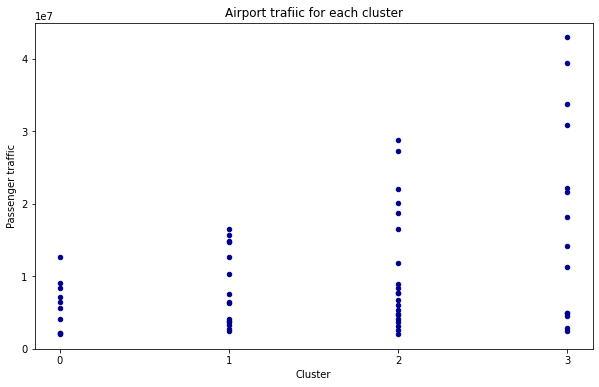

In [33]:
dfpassengers.plot(kind='scatter', x='Label', y='Passengers', figsize=(10, 6), color='darkblue')
plt.title('Airport trafiic for each cluster')
plt.xlabel('Cluster')
plt.ylabel('Passenger traffic')
plt.xticks(np.arange(0, 4, 1))
plt.yticks(np.arange(0, 50000000, 10000000))
#plt.ylim(0, 50000000)
plt.show()

An interesting fact is that each cluster includes airports with an increasingly higher traffic. This is an inference from our analysis, since passenger traffic was not used in our clustering strategy. 

### __6. Repeat the clustering for the restaurants only__

In the previous sections, we decided to ignore the restaurant because their very strong dominance in term of proportion compared to the other venues might bias the analysis. In theis section we study the clustering of the restaurants only, according to their cuisine, and ignore the other types of venues.

First, we retrive the restaurants from the table vmean and drop the other columns.

In [34]:
mycols=['Airport name']+mydict['Restaurant']
vmean3=vmean[mycols]
vmean3.head()

,Airport name,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Austin–Bergstrom International Airport,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.03,0.01,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.02,0.00
1,Baltimore/Washington International Airport,0.02,0.05,0.0,0.0,0.0,0.02,0.0,0.01,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.01,0.00
2,Bradley International Airport,0.00,0.06,0.0,0.0,0.0,0.03,0.0,0.01,0.02,...,0.00,0.01,0.01,0.0,0.0,0.0,0.00,0.0,0.01,0.01
3,Charlotte Douglas International Airport,0.00,0.02,0.0,0.0,0.0,0.02,0.0,0.04,0.00,...,0.01,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.01,0.00
4,Chicago Midway International Airport,0.00,0.03,0.0,0.0,0.0,0.00,0.0,0.02,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00


Next, similarly to what was done before, we find the 10 restaurant types with the highest proportion.

In [35]:
numax=10
# Create columns
colist=['Airport name']
for i in range(numax):
    colist.append("C"+str(i+1))

# Create dataframe
venues_sorted3=pd.DataFrame(columns=colist)

# Populate dataframe
nmax=numax+1
for i in vmean3.index:
    myrow=vmean3.iloc[i,1:].sort_values(ascending=False)
    myrow2=[vmean3.iloc[i,0]]+list(myrow.index.values)
    venues_sorted3.loc[i,:]=myrow2[0:11]
    
venues_sorted3.head()

,Airport name,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,Austin–Bergstrom International Airport,Food Truck,Pizza Place,BBQ Joint,Italian Restaurant,Restaurant,Taco Place,Burger Joint,Vietnamese Restaurant,Asian Restaurant,Bagel Shop
1,Baltimore/Washington International Airport,Seafood Restaurant,Sandwich Place,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Asian Restaurant,Italian Restaurant,Snack Place,Sushi Restaurant
2,Bradley International Airport,American Restaurant,Italian Restaurant,Sandwich Place,Breakfast Spot,Pizza Place,Asian Restaurant,Diner,Bagel Shop,Wings Joint,Vietnamese Restaurant
3,Charlotte Douglas International Airport,Mexican Restaurant,BBQ Joint,Restaurant,Greek Restaurant,American Restaurant,Pizza Place,Asian Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Mediterranean Restaurant
4,Chicago Midway International Airport,Pizza Place,Mexican Restaurant,Breakfast Spot,American Restaurant,Hot Dog Joint,BBQ Joint,Middle Eastern Restaurant,Taco Place,Italian Restaurant,Diner


Find the optimum number of clusters for k-means, by scanning k from 2 to 10.

In [36]:
# Drop the airport name
venues_train=vmean3.drop('Airport name',axis=1).copy()

# Set the maximum number of clusters for error analysis and initialyze the error table to 0
kmax=10
error=np.zeros(kmax+1)

# Loop through each number of clusters from 2 to 10
for i in range(2,kmax+1):
    order=i
    #print('Order=',order)
    # Cluster the dataset into i groups
    kmean_loc=KMeans(n_clusters=order, random_state=0,n_init=1)
    kmean_loc.fit(venues_train)
    
    # Copy the dataset and add a column contaning the cluster labels
    mydf=venues_train.copy()
    mydf['Label']=kmean_loc.labels_
    
    # Compute sum of squared error, ie: the sum of squared distance from each point to the centroid
    for j in range(i):
        A=mydf[mydf['Label']==j].drop('Label',axis=1).to_numpy()
        error[i]=error[i]+((A-kmean_loc.cluster_centers_[j])**2).mean()
    
    # Compute the mean squared error
    error[i]=error[i]/i
    print('Error at k=',i,'=',error[i])

Error at k= 2 = 5.86211353662187e-05
Error at k= 3 = 5.4367510966753904e-05
Error at k= 4 = 4.729226569043442e-05
Error at k= 5 = 4.444908270232854e-05
Error at k= 6 = 4.367164073779095e-05
Error at k= 7 = 3.841786161488327e-05
Error at k= 8 = 3.581742338450479e-05
Error at k= 9 = 3.622790357806378e-05
Error at k= 10 = 3.5865997897419966e-05


Text(0, 0.5, 'Error')

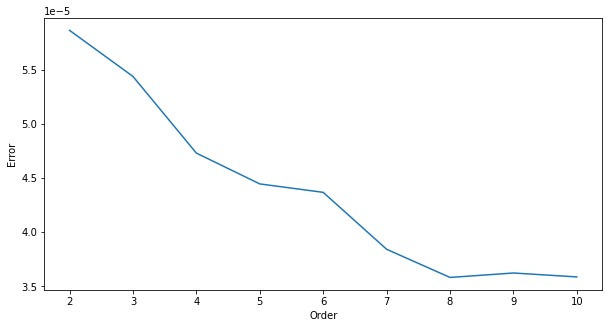

In [37]:
# Plot the error for each number of clusters from 2 to 10
orders=range(2,kmax+1)
plt.figure(figsize=(10,5))
plt.plot(orders,error[2:11])
plt.xlabel('Order')
plt.ylabel('Error')

We find that the optimum k is 5. <br>
We then re-compute the 5-mean clustering.

In [38]:
mykmean=KMeans(n_clusters=5, random_state=0,n_init=1)
mykmean.fit(venues_train)
mykmean.labels_[0:10]

array([0, 3, 4, 0, 2, 3, 3, 1, 3, 1], dtype=int32)

Store the airports and respective cluster numbers into a dataframe.

In [39]:
airport_labelled=pd.DataFrame(columns=['Airport name','Label'])
airport_labelled['Airport name']=vmean3['Airport name']
airport_labelled['Label']=mykmean.labels_
airport_labelled.head()

,Airport name,Label
0,Austin–Bergstrom International Airport,0
1,Baltimore/Washington International Airport,3
2,Bradley International Airport,4
3,Charlotte Douglas International Airport,0
4,Chicago Midway International Airport,2


In [40]:
finaldf=airport_labelled.join(df.set_index('Airport name'), on='Airport name')
finaldf.head()

,Airport name,Label,Code,City,State,Passengers,Latitude,Longitude
0,Austin–Bergstrom International Airport,0,AUS,Austin,TX,"6,472,579",30.19444,-97.67000
1,Baltimore/Washington International Airport,3,BWI,Baltimore,MD,"11,204,511",39.17528,-76.66833
2,Bradley International Airport,4,BDL,Hartford,CT,"2,427,478",41.93917,-72.68333
3,Charlotte Douglas International Airport,0,CLT,Charlotte,NC,"27,205,082",35.21389,-80.94306
4,Chicago Midway International Airport,2,MDW,Chicago,IL,"8,853,948",41.78611,-87.75250


Plot the clusters on a map.

In [42]:
# create map
latitude=40.0
longitude=-105.0
nclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=4.45)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i + x + (i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, city, cluster in zip(finaldf['Latitude'], finaldf['Longitude'], finaldf['Airport name'], finaldf['City'], finaldf['Label']):
    label='{}, {}, {}'.format(name, city, ' Cluster ' + str(cluster))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

Github does not display folium maps so I am including a .PNG version.

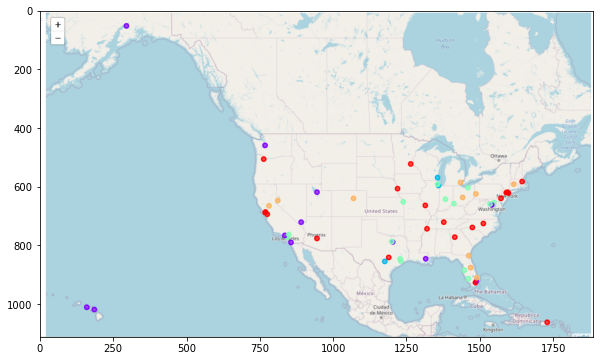

In [4]:
plt.figure(figsize = (10,6))
im2 = img.imread('map_cluster2.PNG')
plt.imshow(im2)

Repeat the same type of cluster analysis as the one in the previous section.

In [43]:
analysis=airport_labelled.join(venues_sorted3.set_index('Airport name'), on='Airport name')
analysis.head()

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,Austin–Bergstrom International Airport,0,Food Truck,Pizza Place,BBQ Joint,Italian Restaurant,Restaurant,Taco Place,Burger Joint,Vietnamese Restaurant,Asian Restaurant,Bagel Shop
1,Baltimore/Washington International Airport,3,Seafood Restaurant,Sandwich Place,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Asian Restaurant,Italian Restaurant,Snack Place,Sushi Restaurant
2,Bradley International Airport,4,American Restaurant,Italian Restaurant,Sandwich Place,Breakfast Spot,Pizza Place,Asian Restaurant,Diner,Bagel Shop,Wings Joint,Vietnamese Restaurant
3,Charlotte Douglas International Airport,0,Mexican Restaurant,BBQ Joint,Restaurant,Greek Restaurant,American Restaurant,Pizza Place,Asian Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Mediterranean Restaurant
4,Chicago Midway International Airport,2,Pizza Place,Mexican Restaurant,Breakfast Spot,American Restaurant,Hot Dog Joint,BBQ Joint,Middle Eastern Restaurant,Taco Place,Italian Restaurant,Diner


In [44]:
analysis[analysis['Label']==0]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,Austin–Bergstrom International Airport,0,Food Truck,Pizza Place,BBQ Joint,Italian Restaurant,Restaurant,Taco Place,Burger Joint,Vietnamese Restaurant,Asian Restaurant,Bagel Shop
3,Charlotte Douglas International Airport,0,Mexican Restaurant,BBQ Joint,Restaurant,Greek Restaurant,American Restaurant,Pizza Place,Asian Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Mediterranean Restaurant
12,Eppley Airfield,0,Pizza Place,Steakhouse,Sushi Restaurant,Mexican Restaurant,Seafood Restaurant,Burger Joint,Breakfast Spot,BBQ Joint,Fast Food Restaurant,New American Restaurant
15,Hartsfield-Jackson International Airport,0,Burger Joint,Pizza Place,Breakfast Spot,Seafood Restaurant,Mexican Restaurant,BBQ Joint,Restaurant,Burrito Place,Southern / Soul Food Restaurant,Taco Place
18,John F. Kennedy International Airport,0,Caribbean Restaurant,Pizza Place,Burger Joint,Italian Restaurant,Bagel Shop,Mexican Restaurant,Sushi Restaurant,Greek Restaurant,BBQ Joint,Seafood Restaurant
23,LaGuardia Airport,0,Pizza Place,Bagel Shop,Thai Restaurant,Food Truck,Italian Restaurant,Greek Restaurant,Sandwich Place,Tibetan Restaurant,Indian Restaurant,Vietnamese Restaurant
24,Logan International Airport,0,Pizza Place,Seafood Restaurant,Italian Restaurant,Restaurant,New American Restaurant,Mexican Restaurant,Sandwich Place,French Restaurant,Greek Restaurant,Breakfast Spot
27,Luis Muñoz Marín International Airport,0,Caribbean Restaurant,Food Truck,Latin American Restaurant,BBQ Joint,Restaurant,Spanish Restaurant,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Pizza Place
29,Memphis International Airport,0,BBQ Joint,Fried Chicken Joint,Burger Joint,Steakhouse,Mexican Restaurant,Sandwich Place,Southern / Soul Food Restaurant,American Restaurant,Pizza Place,Asian Restaurant
30,Miami International Airport,0,Pizza Place,Italian Restaurant,Cuban Restaurant,Spanish Restaurant,American Restaurant,Restaurant,Argentinian Restaurant,Japanese Restaurant,Mexican Restaurant,Greek Restaurant


In [45]:
mydf=analysis[analysis['Label']==0].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

Pizza Place                        21
Mexican Restaurant                 16
Sandwich Place                     12
BBQ Joint                          12
Italian Restaurant                 11
Burger Joint                       10
Restaurant                          9
Breakfast Spot                      9
American Restaurant                 9
Seafood Restaurant                  8
Greek Restaurant                    6
Southern / Soul Food Restaurant     6
Food Truck                          6
Sushi Restaurant                    5
Diner                               4
Fast Food Restaurant                4
Vietnamese Restaurant               4
Thai Restaurant                     4
New American Restaurant             4
Bagel Shop                          4
Taco Place                          4
Caribbean Restaurant                3
Asian Restaurant                    3
Spanish Restaurant                  3
Vegetarian / Vegan Restaurant       3
Japanese Restaurant                 3
Mediterranea

In [142]:
analysis[analysis['Label']==1]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
7,Dallas Love Field,1,American Restaurant,Seafood Restaurant,French Restaurant,Mexican Restaurant,Burger Joint,Steakhouse,New American Restaurant,Greek Restaurant,Fast Food Restaurant,Taco Place
9,Daniel K. Inouye International Airport,1,Japanese Restaurant,Pizza Place,Seafood Restaurant,Breakfast Spot,Hawaiian Restaurant,Chinese Restaurant,Restaurant,American Restaurant,Noodle House,Thai Restaurant
13,Fort Lauderdale–Hollywood International Airport,1,Seafood Restaurant,American Restaurant,Mexican Restaurant,Restaurant,Sushi Restaurant,Pizza Place,Latin American Restaurant,Hot Dog Joint,Sandwich Place,Italian Restaurant
21,Kahului Airport,1,Asian Restaurant,Food Truck,Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Hawaiian Restaurant,Japanese Restaurant,Comfort Food Restaurant,Pizza Place,New American Restaurant
25,Los Angeles International Airport,1,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Italian Restaurant,Sushi Restaurant,Salad Place,Steakhouse,New American Restaurant
26,Louis Armstrong New Orleans International Airport,1,Seafood Restaurant,American Restaurant,Chinese Restaurant,Vietnamese Restaurant,Italian Restaurant,Burger Joint,Mexican Restaurant,Sushi Restaurant,Fast Food Restaurant,Fried Chicken Joint
28,McCarran International Airport,1,Steakhouse,Burger Joint,American Restaurant,Seafood Restaurant,French Restaurant,Fast Food Restaurant,Snack Place,Mexican Restaurant,Japanese Restaurant,Taco Place
47,Ronald Reagan Washington National Airport,1,American Restaurant,Mediterranean Restaurant,Indian Restaurant,Thai Restaurant,Food Truck,Seafood Restaurant,Portuguese Restaurant,Sushi Restaurant,Salad Place,New American Restaurant
49,Salt Lake City International Airport,1,Mexican Restaurant,Burger Joint,Italian Restaurant,Pizza Place,Seafood Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,New American Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant
51,San Diego International Airport,1,Seafood Restaurant,New American Restaurant,Taco Place,Italian Restaurant,Steakhouse,Sushi Restaurant,Sandwich Place,Restaurant,Breakfast Spot,Mexican Restaurant


In [46]:
mydf=analysis[analysis['Label']==1].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

Seafood Restaurant               12
Mexican Restaurant                9
American Restaurant               7
New American Restaurant           6
Pizza Place                       6
Italian Restaurant                6
Burger Joint                      6
Sushi Restaurant                  6
Fast Food Restaurant              5
Restaurant                        5
Steakhouse                        5
Japanese Restaurant               4
Vegetarian / Vegan Restaurant     3
Breakfast Spot                    3
Mediterranean Restaurant          3
Chinese Restaurant                3
Taco Place                        3
Salad Place                       3
Sandwich Place                    2
French Restaurant                 2
Vietnamese Restaurant             2
Food Truck                        2
Hawaiian Restaurant               2
Thai Restaurant                   2
Snack Place                       1
Fried Chicken Joint               1
Portuguese Restaurant             1
Hot Dog Joint               

In [143]:
analysis[analysis['Label']==2]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
4,Chicago Midway International Airport,2,Pizza Place,Mexican Restaurant,Breakfast Spot,American Restaurant,Hot Dog Joint,BBQ Joint,Middle Eastern Restaurant,Taco Place,Italian Restaurant,Diner
31,Milwaukee Mitchell International Airport,2,Pizza Place,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Italian Restaurant,Restaurant,Vietnamese Restaurant,Sushi Restaurant,New American Restaurant,Middle Eastern Restaurant
50,San Antonio International Airport,2,Mexican Restaurant,Pizza Place,American Restaurant,Thai Restaurant,Seafood Restaurant,Sushi Restaurant,BBQ Joint,Italian Restaurant,Sandwich Place,Burger Joint


In [47]:
mydf=analysis[analysis['Label']==2].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

Mexican Restaurant           3
American Restaurant          3
Pizza Place                  3
Italian Restaurant           3
Middle Eastern Restaurant    2
Sushi Restaurant             2
BBQ Joint                    2
Hot Dog Joint                1
Fast Food Restaurant         1
Breakfast Spot               1
Vietnamese Restaurant        1
Sandwich Place               1
Restaurant                   1
Diner                        1
Thai Restaurant              1
New American Restaurant      1
Burger Joint                 1
Seafood Restaurant           1
Taco Place                   1
Name: index, dtype: int64

In [144]:
analysis[analysis['Label']==3]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
1,Baltimore/Washington International Airport,3,Seafood Restaurant,Sandwich Place,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Asian Restaurant,Italian Restaurant,Snack Place,Sushi Restaurant
5,Cincinnati/Northern Kentucky International Air...,3,American Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Steakhouse,Fast Food Restaurant,Breakfast Spot,Burger Joint,Fried Chicken Joint,Hot Dog Joint
6,Cleveland Hopkins International Airport,3,Mexican Restaurant,Sandwich Place,Burger Joint,Diner,American Restaurant,Pizza Place,Chinese Restaurant,Asian Restaurant,Latin American Restaurant,Seafood Restaurant
8,Dallas/Fort Worth International Airport,3,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Seafood Restaurant,Pizza Place,Food Truck,BBQ Joint,Breakfast Spot,Steakhouse,Burger Joint
14,George Bush Intercontinental Airport,3,Mexican Restaurant,Sandwich Place,Seafood Restaurant,American Restaurant,Fried Chicken Joint,Chinese Restaurant,Steakhouse,Pizza Place,Food Truck,Cajun / Creole Restaurant
16,Indianapolis International Airport,3,Mexican Restaurant,Fast Food Restaurant,American Restaurant,Breakfast Spot,Thai Restaurant,Burger Joint,Pizza Place,Restaurant,Sandwich Place,Steakhouse
20,John Wayne Airport,3,Fast Food Restaurant,American Restaurant,Italian Restaurant,Steakhouse,Tapas Restaurant,Seafood Restaurant,Sandwich Place,Japanese Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant
22,Kansas City International Airport,3,Fast Food Restaurant,Pizza Place,American Restaurant,Mexican Restaurant,Sandwich Place,Sushi Restaurant,Indian Restaurant,Burger Joint,Breakfast Spot,Steakhouse
36,O'Hare International Airport,3,Pizza Place,Sandwich Place,Hot Dog Joint,Mexican Restaurant,Italian Restaurant,Steakhouse,Snack Place,American Restaurant,Fast Food Restaurant,Seafood Restaurant
38,Ontario International Airport,3,Fast Food Restaurant,Mexican Restaurant,Italian Restaurant,Sandwich Place,Sushi Restaurant,Breakfast Spot,Pizza Place,Restaurant,Burger Joint,Steakhouse


In [48]:
mydf=analysis[analysis['Label']==3].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

Mexican Restaurant                 14
Pizza Place                        12
Fast Food Restaurant               12
Sandwich Place                     11
American Restaurant                11
Steakhouse                         10
Seafood Restaurant                  9
Burger Joint                        7
Breakfast Spot                      6
Italian Restaurant                  5
Sushi Restaurant                    4
Restaurant                          4
Hot Dog Joint                       2
Fried Chicken Joint                 2
Japanese Restaurant                 2
Chinese Restaurant                  2
Diner                               2
Asian Restaurant                    2
BBQ Joint                           2
Snack Place                         2
Food Truck                          2
Vietnamese Restaurant               2
Cajun / Creole Restaurant           2
Turkish Restaurant                  1
Vegetarian / Vegan Restaurant       1
Southern / Soul Food Restaurant     1
Kebab Restau

In [145]:
analysis[analysis['Label']==4]

,Airport name,Label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
2,Bradley International Airport,4,American Restaurant,Italian Restaurant,Sandwich Place,Breakfast Spot,Pizza Place,Asian Restaurant,Diner,Bagel Shop,Wings Joint,Vietnamese Restaurant
10,Denver International Airport,4,American Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Burger Joint,Sushi Restaurant,Steakhouse,Restaurant,Snack Place,Breakfast Spot
11,Detroit Metropolitan Airport,4,Fast Food Restaurant,Sandwich Place,American Restaurant,Italian Restaurant,Pizza Place,Chinese Restaurant,Middle Eastern Restaurant,Steakhouse,Mexican Restaurant,Diner
17,Jacksonville International Airport,4,Sandwich Place,Pizza Place,American Restaurant,Chinese Restaurant,Seafood Restaurant,BBQ Joint,Steakhouse,Breakfast Spot,Fast Food Restaurant,Mexican Restaurant
19,John Glenn Columbus International Airport,4,American Restaurant,Mexican Restaurant,Pizza Place,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant,Steakhouse,Comfort Food Restaurant,Diner,Mongolian Restaurant
39,Orlando International Airport,4,American Restaurant,Steakhouse,Sandwich Place,Seafood Restaurant,Mexican Restaurant,New American Restaurant,Pizza Place,Tex-Mex Restaurant,Fast Food Restaurant,Burger Joint
40,Palm Beach International Airport,4,American Restaurant,Italian Restaurant,Cuban Restaurant,Diner,Mexican Restaurant,Sandwich Place,Restaurant,Steakhouse,Sushi Restaurant,Pizza Place
43,Pittsburgh International Airport,4,Italian Restaurant,Mexican Restaurant,American Restaurant,Wings Joint,Burger Joint,Pizza Place,BBQ Joint,Restaurant,Bagel Shop,Sushi Restaurant
46,Reno–Tahoe International Airport,4,American Restaurant,Breakfast Spot,Sandwich Place,Fast Food Restaurant,Italian Restaurant,Burger Joint,Sushi Restaurant,Steakhouse,Fried Chicken Joint,Mexican Restaurant
48,Sacramento International Airport,4,American Restaurant,Sushi Restaurant,Sandwich Place,Mexican Restaurant,Thai Restaurant,Chinese Restaurant,New American Restaurant,Burger Joint,Fast Food Restaurant,Pizza Place


In [49]:
mydf=analysis[analysis['Label']==4].copy()
mycols=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',]
mydf[mycols].melt(var_name='columns', value_name='index')['index'].value_counts()

American Restaurant          10
Pizza Place                   9
Sandwich Place                8
Mexican Restaurant            8
Steakhouse                    7
Fast Food Restaurant          6
Sushi Restaurant              6
Italian Restaurant            6
Burger Joint                  5
Breakfast Spot                4
Diner                         4
Chinese Restaurant            3
Restaurant                    3
Seafood Restaurant            2
Wings Joint                   2
Bagel Shop                    2
BBQ Joint                     2
New American Restaurant       2
Cuban Restaurant              1
Fried Chicken Joint           1
Snack Place                   1
Vietnamese Restaurant         1
Thai Restaurant               1
Comfort Food Restaurant       1
Tex-Mex Restaurant            1
Mongolian Restaurant          1
Middle Eastern Restaurant     1
Mediterranean Restaurant      1
Asian Restaurant              1
Name: index, dtype: int64

<br>
We can then describe the clusters as follows: <br>
* Cluster 0 has a high concentration of Italian restaurants, BBQs and fast-food, but less than average Asian restaurants; <br>
* Cluster 1 has a high concentration of seafood and American restaurants; <br>
* Cluster 2 has a high concentration of Italian and American restaurants; <br>
* Cluster 3 has a high concentration of pizza places, fast food, American, seafood restaurants and steak houses; <br>
* Cluster 4 has a high concentration of American restaurants, fast food, Italian and Asian restaurants. <br>